In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

from cataclop.ml.pipeline import factories

In [2]:
program = factories.Program.factory('default', version='1.1')

In [3]:
program.train(dataset_params = {
    #'from': '2013-05-10'
    'from': '2016-01-01',
    'to': '2018-10-01',
    'categories': ['PLAT']
})

preparing model data
training knn_10
mea: 4.101027445171377
training knn_20
mea: 4.067935371490488
training knn_30
mea: 4.061475583718516
training knn_40
mea: 4.054743755914907
training knn_100
mea: 4.031848235471616
training mlp_10
/Users/pourquoi/.local/share/virtualenvs/cataclop-django-M9amAh3O/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
mea: 3.949256002995631
training mlp_20
mea: 3.9198346526276713
training mlp_30
mea: 3.8896206456037605
training mlp_40
mea: 3.945535350114506
training mlp_100
mea: 3.8152201301247084
training gbr_10
mea: 4.05682797138157
training gbr_20
mea: 4.2448832501753495
training gbr_30
mea: 4.364372225907795
training gbr_40
mea: 4.420072690798553
training gbr_100
mea: 4.560370432455275
training rf_10
mea: 4.975553362345364
training rf_20
mea: 4.948090500046047
training

In [4]:
program.dataset.save()
print(program.dataset.hash)
program.model.save()
print(program.model.hash)

86e6109f864e3163f1e68a888efbd5b8
8948b3ec9f8d1a9f09e4610a770ae0f9


In [5]:
print('{} races from {} to {}'.format(program.df.race_id.nunique(), program.df.start_at.min(), program.df.start_at.max()))

13194 races from 2016-01-01 11:15:00 to 2018-07-31 20:45:00


In [6]:
import pandas as pd
from cataclop.ml import preprocessing

for model in program.model.models:
    clf = model['estimators'][-1]['pipeline'].steps[-1][1]
    if hasattr(clf, 'feature_importances_'):
        fi = pd.Series(clf.feature_importances_, index=program.model.features+preprocessing.get_dummy_features(model['estimators'][-1]['dummies']))
        print(model['name'])
        print(fi.sort_values(ascending=False)[0:100])
        print("---\n")


gbr_10
hist_1_pos                                         0.221697
odds_8                                             0.171677
odds_9                                             0.147830
victory_earnings_r                                 0.115757
placed_earnings_r                                  0.077212
declared_player_count                              0.060240
odds_6                                             0.031730
odds_4                                             0.030067
prev_year_earnings_std                             0.027470
victory_earnings                                   0.026174
odds_7                                             0.025452
placed_earnings_std                                0.011208
handicap_weight_r                                  0.009542
odds_0                                             0.008811
victory_earnings_std                               0.008343
hist_2_pos                                         0.007123
placed_2_count_r                 

In [7]:
df = program.df

races = df.groupby('race_id')
for (id, race) in races:
    for model in program.model.models:
        df.loc[race.index, 'pred_{}_std'.format(model['name'])] = race['pred_{}_1'.format(model['name'])].std()
        df.loc[race.index, 'pred_{}_min'.format(model['name'])] = race['pred_{}_1'.format(model['name'])].min()
        df.loc[race.index, 'pred_{}_max'.format(model['name'])] = race['pred_{}_1'.format(model['name'])].max()

In [8]:
stacked_features = ['declared_player_count'] + ['odds_{:d}'.format(i) for i in range(10)]

stacked_features = stacked_features + ['pred_{}_1'.format(model['name']) for model in program.model.models]
stacked_features = stacked_features + ['pred_{}_std'.format(model['name']) for model in program.model.models]
stacked_features = stacked_features + ['pred_{}_min'.format(model['name']) for model in program.model.models]
stacked_features = stacked_features + ['pred_{}_max'.format(model['name']) for model in program.model.models]

stacked_features



['declared_player_count',
 'odds_0',
 'odds_1',
 'odds_2',
 'odds_3',
 'odds_4',
 'odds_5',
 'odds_6',
 'odds_7',
 'odds_8',
 'odds_9',
 'pred_knn_10_1',
 'pred_knn_20_1',
 'pred_knn_30_1',
 'pred_knn_40_1',
 'pred_knn_100_1',
 'pred_mlp_10_1',
 'pred_mlp_20_1',
 'pred_mlp_30_1',
 'pred_mlp_40_1',
 'pred_mlp_100_1',
 'pred_gbr_10_1',
 'pred_gbr_20_1',
 'pred_gbr_30_1',
 'pred_gbr_40_1',
 'pred_gbr_100_1',
 'pred_rf_10_1',
 'pred_rf_20_1',
 'pred_rf_30_1',
 'pred_rf_40_1',
 'pred_rf_100_1',
 'pred_knn_10_std',
 'pred_knn_20_std',
 'pred_knn_30_std',
 'pred_knn_40_std',
 'pred_knn_100_std',
 'pred_mlp_10_std',
 'pred_mlp_20_std',
 'pred_mlp_30_std',
 'pred_mlp_40_std',
 'pred_mlp_100_std',
 'pred_gbr_10_std',
 'pred_gbr_20_std',
 'pred_gbr_30_std',
 'pred_gbr_40_std',
 'pred_gbr_100_std',
 'pred_rf_10_std',
 'pred_rf_20_std',
 'pred_rf_30_std',
 'pred_rf_40_std',
 'pred_rf_100_std',
 'pred_knn_10_min',
 'pred_knn_20_min',
 'pred_knn_30_min',
 'pred_knn_40_min',
 'pred_knn_100_min',
 'pre

In [9]:
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, MinMaxScaler, RobustScaler


df['pred_stacked_1'] = 0

from sklearn.model_selection import KFold, GroupKFold

groups = df['race_id'].values

group_kfold = GroupKFold(n_splits=program.model.params['kfolds'])

splits = list(group_kfold.split(df.values, df['position'].values, groups))

for train_index, test_index in splits:
    
    X_train = df[stacked_features].iloc[train_index].copy()
    
    idx = (df.iloc[train_index]['final_odds_ref'] < 20)
    X_train = X_train[ idx ]
    y_train = df['target'].iloc[train_index][ idx ]
    
    X_test = df[stacked_features].iloc[test_index].copy()
    y_test = df['target'].iloc[test_index]
    
    X_train = X_train.values
    X_test = X_test.values
    
    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    y_train = y_train / y_train.max()
    y_test = y_test / y_train.max()
    
    #estimator = MLPRegressor(activation='logistic', hidden_layer_sizes=(100,), random_state=program.model.params['seed'])
    estimator = RandomForestRegressor(n_estimators=100)
    #estimator = linear_model.Ridge(alpha=.5)
    
    estimator.fit(X_train, y_train.values)
    
    p = estimator.predict(X_test)
    
    idx = df.iloc[test_index].index
    df.loc[idx, 'pred_stacked_1'] = p
    
    

In [10]:
import pandas as pd
from cataclop.ml import preprocessing

if hasattr(estimator, 'feature_importances_'):
    fi = pd.Series(estimator.feature_importances_, index=stacked_features)
    print(fi.sort_values(ascending=False)[0:100])
    
if hasattr(estimator, 'coef_'):
    fi = pd.Series(estimator.coef_, index=stacked_features)
    print(fi.sort_values(ascending=False)[0:100])

pred_rf_100_1            0.042000
pred_knn_20_1            0.040770
pred_gbr_100_1           0.039138
pred_rf_10_1             0.037003
pred_rf_40_1             0.035917
pred_rf_20_1             0.035691
pred_knn_10_1            0.034504
pred_knn_100_1           0.033908
pred_knn_40_1            0.032790
pred_knn_30_1            0.031821
pred_rf_30_1             0.030633
pred_gbr_30_1            0.027374
pred_gbr_40_1            0.026941
pred_gbr_20_1            0.025241
pred_gbr_10_1            0.023071
pred_knn_20_min          0.013731
pred_knn_100_min         0.012587
pred_knn_10_min          0.011346
odds_1                   0.011030
pred_rf_10_min           0.010825
pred_rf_100_min          0.010682
pred_rf_20_min           0.010551
odds_5                   0.010531
odds_2                   0.010180
pred_knn_30_min          0.009985
odds_9                   0.009620
pred_rf_40_min           0.009382
pred_knn_40_min          0.009334
pred_rf_30_min           0.009179
pred_gbr_100_m

In [11]:
from cataclop.ml import exploration

exploration.random_race(df, cols=['position', 'declared_player_count', 'sub_category', 'num', 'final_odds', 'final_odds_ref', 'pred_stacked_1', 'pred_rf_100_1'])

position  declared_player_count         sub_category  num  \
race_id                                                                    
18299   77317       6.0                      9  COURSE_A_CONDITIONS    1   
        77318       2.0                      9  COURSE_A_CONDITIONS    2   
        77319       5.0                      9  COURSE_A_CONDITIONS    3   
        77320       1.0                      9  COURSE_A_CONDITIONS    4   
        77321       3.0                      9  COURSE_A_CONDITIONS    5   
        77322       8.0                      9  COURSE_A_CONDITIONS    6   
        77323       9.0                      9  COURSE_A_CONDITIONS    7   
        77324       4.0                      9  COURSE_A_CONDITIONS    8   
        77325       7.0                      9  COURSE_A_CONDITIONS    9   

               final_odds  final_odds_ref  pred_stacked_1  pred_rf_100_1  
race_id                                                                   
18299   77317        18.4            11.3        0.020303       6.331500  
        77318        11.3             8.3        0.018075       2.803000  
        77319        23.3            13.7        0.010646       3.383000  
        77320         4.3             4.0        0.013854       5.544500  
        77321         5.1             8.1        0.013873       2.487000  
        77322        13.7            11.8        0.016315       3.077000  
        77323         2.8             3.1        0.005861       7.577633  
        77324        10.4            13.3        0.005861       7.577633  
        77325        19.3            18.1        0.005861       7.577633

In [12]:
program.bet(N=1, max_odds=20, targets=['pred_stacked_1'] + ['pred_{}_1'.format(model['name']) for model in program.model.models])
bets = program.bets
bets['profit'].describe()

count    161968.000000
mean         -0.187575
std           3.509801
min          -1.000000
25%          -1.000000
50%          -1.000000
75%          -1.000000
max          77.200000
Name: profit, dtype: float64

In [13]:
bets = bets.reset_index(drop=True)

---
COURSE_A_CONDITIONS	-5642.70	+29680.00	+29680.00
---
pred_knn_10_1: 	 -456.50 	 +3085 	 -0.15
pred_knn_20_1: 	 -598.60 	 +3040 	 -0.20
pred_knn_40_1: 	 -642.40 	 +2953 	 -0.22
pred_knn_30_1: 	 -583.70 	 +2950 	 -0.20
pred_knn_100_1: 	 -837.50 	 +2864 	 -0.29
pred_gbr_10_1: 	 -662.90 	 +2721 	 -0.24
pred_gbr_20_1: 	 -515.00 	 +2587 	 -0.20
pred_gbr_30_1: 	 -567.50 	 +2556 	 -0.22
pred_gbr_40_1: 	 -542.50 	 +2527 	 -0.21
pred_gbr_100_1: 	 -364.40 	 +2485 	 -0.15


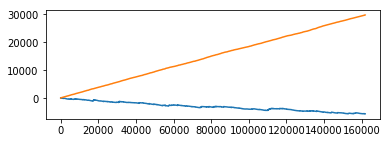

---
HANDICAP	-3631.60	+17621.00	+17621.00
---
pred_knn_10_1: 	 -471.60 	 +1975 	 -0.24
pred_knn_20_1: 	 -464.90 	 +1887 	 -0.25
pred_knn_100_1: 	 -469.90 	 +1882 	 -0.25
pred_knn_30_1: 	 -517.40 	 +1884 	 -0.27
pred_knn_40_1: 	 -562.70 	 +1881 	 -0.30
pred_gbr_10_1: 	 -185.50 	 +1674 	 -0.11
pred_gbr_20_1: 	 -172.40 	 +1634 	 -0.11
pred_gbr_100_1: 	 -295.90 	 +1576 	 -0.19
pred_gbr_30_1: 	 -191.00 	 +1573 	 -0.12
pred_gbr_40_1: 	 -260.90 	 +1560 	 -0.17


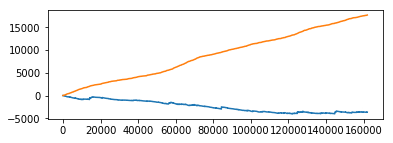

---
HANDICAP_DIVISE	-1259.60	+8822.00	+8822.00
---
pred_knn_20_1: 	 -114.00 	 +1040 	 -0.11
pred_knn_40_1: 	 -228.50 	 +1036 	 -0.22
pred_knn_10_1: 	 -197.60 	 +1030 	 -0.19
pred_knn_30_1: 	 -194.50 	 +1018 	 -0.19
pred_knn_100_1: 	 -13.10 	 +986 	 -0.01
pred_gbr_100_1: 	 -184.90 	 +774 	 -0.24
pred_gbr_10_1: 	 -159.60 	 +748 	 -0.21
pred_gbr_40_1: 	 -28.50 	 +735 	 -0.04
pred_gbr_30_1: 	 -131.60 	 +726 	 -0.18
pred_gbr_20_1: 	 +6.10 	 +714 	 +0.01


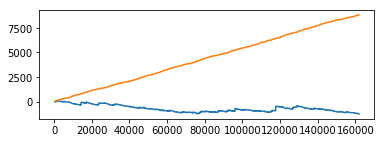

---
A_RECLAMER	-1317.90	+6561.00	+6561.00
---
pred_knn_10_1: 	 -334.40 	 +743 	 -0.45
pred_knn_20_1: 	 -137.80 	 +718 	 -0.19
pred_knn_30_1: 	 -80.40 	 +696 	 -0.12
pred_knn_40_1: 	 -159.30 	 +683 	 -0.23
pred_knn_100_1: 	 -152.90 	 +661 	 -0.23
pred_gbr_10_1: 	 -121.00 	 +618 	 -0.20
pred_gbr_20_1: 	 -21.70 	 +603 	 -0.04
pred_gbr_100_1: 	 -44.10 	 +591 	 -0.07
pred_gbr_40_1: 	 -81.30 	 +586 	 -0.14
pred_gbr_30_1: 	 -178.20 	 +578 	 -0.31


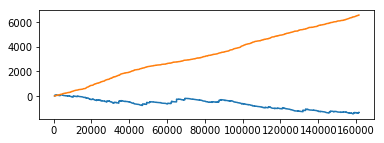

---
HANDICAP_CATEGORIE_DIVISE	-183.00	+3329.00	+3329.00
---
pred_knn_10_1: 	 -45.40 	 +401 	 -0.11
pred_knn_20_1: 	 +13.50 	 +391 	 +0.03
pred_knn_30_1: 	 -4.10 	 +368 	 -0.01
pred_knn_100_1: 	 -89.80 	 +367 	 -0.24
pred_knn_40_1: 	 -90.00 	 +357 	 -0.25
pred_gbr_100_1: 	 +59.60 	 +302 	 +0.20
pred_gbr_40_1: 	 -1.10 	 +287 	 -0.00
pred_gbr_10_1: 	 -27.80 	 +286 	 -0.10
pred_gbr_30_1: 	 -20.20 	 +283 	 -0.07
pred_gbr_20_1: 	 +30.30 	 +279 	 +0.11


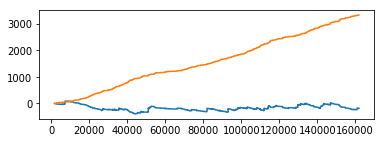

---
HANDICAP_DE_CATEGORIE	+1209.10	+1606.00	+1606.00
---
pred_knn_20_1: 	 +136.20 	 +176 	 +0.77
pred_knn_40_1: 	 +234.90 	 +175 	 +1.34
pred_knn_10_1: 	 +30.80 	 +174 	 +0.18
pred_knn_30_1: 	 +142.00 	 +169 	 +0.84
pred_knn_100_1: 	 +74.20 	 +165 	 +0.45
pred_gbr_40_1: 	 +148.40 	 +157 	 +0.95
pred_gbr_30_1: 	 +142.30 	 +149 	 +0.96
pred_gbr_10_1: 	 +118.30 	 +148 	 +0.80
pred_gbr_100_1: 	 +61.60 	 +145 	 +0.42
pred_gbr_20_1: 	 +124.40 	 +144 	 +0.86


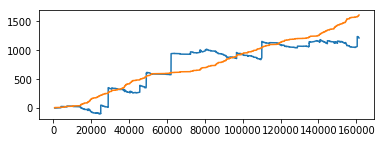

---
GROUPE_III	-194.30	+1298.00	+1298.00
---
pred_knn_10_1: 	 -31.90 	 +146 	 -0.22
pred_knn_20_1: 	 -5.40 	 +145 	 -0.04
pred_knn_100_1: 	 -54.60 	 +143 	 -0.38
pred_knn_40_1: 	 -18.60 	 +143 	 -0.13
pred_knn_30_1: 	 +46.40 	 +133 	 +0.35
pred_gbr_10_1: 	 +33.80 	 +118 	 +0.29
pred_gbr_20_1: 	 -37.90 	 +116 	 -0.33
pred_gbr_100_1: 	 -15.60 	 +113 	 -0.14
pred_gbr_40_1: 	 -44.30 	 +112 	 -0.40
pred_gbr_30_1: 	 -47.20 	 +110 	 -0.43


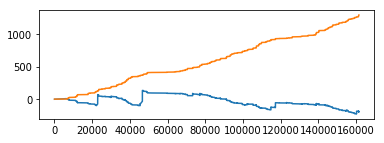

---
GROUPE_I	-353.80	+1132.00	+1132.00
---
pred_knn_30_1: 	 +29.30 	 +149 	 +0.20
pred_knn_40_1: 	 -66.10 	 +143 	 -0.46
pred_knn_10_1: 	 -4.00 	 +119 	 -0.03
pred_knn_100_1: 	 -16.10 	 +133 	 -0.12
pred_knn_20_1: 	 +0.30 	 +118 	 +0.00
pred_gbr_100_1: 	 -65.60 	 +96 	 -0.68
pred_gbr_40_1: 	 -58.50 	 +87 	 -0.67
pred_gbr_30_1: 	 -56.40 	 +82 	 -0.69
pred_gbr_20_1: 	 -52.70 	 +78 	 -0.68
pred_gbr_10_1: 	 -61.50 	 +76 	 -0.81


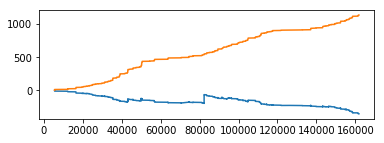

---
GROUPE_II	-231.60	+1038.00	+1038.00
---
pred_knn_40_1: 	 -2.80 	 +117 	 -0.02
pred_knn_100_1: 	 -51.60 	 +112 	 -0.46
pred_knn_20_1: 	 -25.20 	 +111 	 -0.23
pred_knn_10_1: 	 -4.90 	 +108 	 -0.05
pred_knn_30_1: 	 -37.40 	 +106 	 -0.35
pred_gbr_10_1: 	 -38.50 	 +101 	 -0.38
pred_gbr_100_1: 	 +14.80 	 +95 	 +0.16
pred_gbr_20_1: 	 -34.40 	 +94 	 -0.37
pred_gbr_30_1: 	 -25.30 	 +87 	 -0.29
pred_gbr_40_1: 	 -22.60 	 +86 	 -0.26


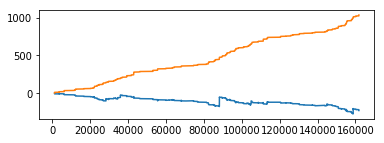

---
COURSE_A_CONDITION_QUALIF_HP	+490.50	+879.00	+879.00
---
pred_knn_40_1: 	 +81.00 	 +100 	 +0.81
pred_knn_20_1: 	 +13.50 	 +96 	 +0.14
pred_knn_30_1: 	 +4.90 	 +96 	 +0.05
pred_knn_10_1: 	 +30.90 	 +95 	 +0.33
pred_gbr_10_1: 	 +71.50 	 +88 	 +0.81
pred_knn_100_1: 	 +26.20 	 +85 	 +0.31
pred_gbr_40_1: 	 +113.00 	 +83 	 +1.36
pred_gbr_30_1: 	 +93.50 	 +82 	 +1.14
pred_gbr_20_1: 	 +56.40 	 +80 	 +0.70
pred_gbr_100_1: 	 +2.60 	 +71 	 +0.04


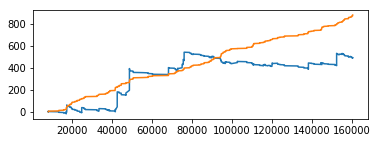

---
INCONNU	-80.40	+590.00	+590.00
---
pred_knn_10_1: 	 -42.20 	 +65 	 -0.65
pred_knn_100_1: 	 -4.70 	 +60 	 -0.08
pred_knn_30_1: 	 -16.80 	 +62 	 -0.27
pred_knn_20_1: 	 -31.70 	 +61 	 -0.52
pred_knn_40_1: 	 +8.70 	 +55 	 +0.16
pred_gbr_100_1: 	 +14.50 	 +53 	 +0.27
pred_gbr_20_1: 	 -15.30 	 +53 	 -0.29
pred_gbr_30_1: 	 +15.50 	 +52 	 +0.30
pred_gbr_10_1: 	 -14.30 	 +52 	 -0.27
pred_gbr_40_1: 	 +30.90 	 +52 	 +0.59


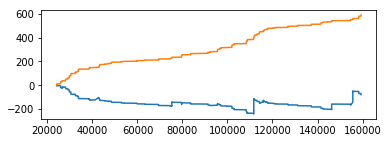

---
QUALIFICATION_ACCAF	-10.10	+91.00	+91.00
---
pred_knn_10_1: 	 -2.90 	 +12 	 -0.24
pred_knn_20_1: 	 +2.70 	 +11 	 +0.25
pred_knn_100_1: 	 -8.20 	 +11 	 -0.75
pred_knn_30_1: 	 -4.50 	 +11 	 -0.41
pred_knn_40_1: 	 -8.00 	 +8 	 -1.00
pred_gbr_40_1: 	 +1.50 	 +7 	 +0.21
pred_gbr_30_1: 	 +1.50 	 +7 	 +0.21
pred_gbr_10_1: 	 +7.80 	 +7 	 +1.11
pred_gbr_20_1: 	 +2.50 	 +6 	 +0.42
pred_gbr_100_1: 	 +2.50 	 +6 	 +0.42


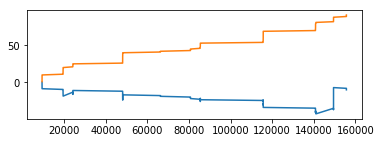

---
HANDICAP_A_RECLAMER	-63.50	+73.00	+73.00
---
pred_knn_20_1: 	 -10.00 	 +10 	 -1.00
pred_knn_10_1: 	 -10.00 	 +10 	 -1.00
pred_knn_30_1: 	 -8.00 	 +8 	 -1.00
pred_knn_40_1: 	 -8.00 	 +8 	 -1.00
pred_knn_100_1: 	 +2.50 	 +7 	 +0.36
pred_gbr_100_1: 	 -7.00 	 +7 	 -1.00
pred_gbr_20_1: 	 -6.00 	 +6 	 -1.00
pred_gbr_40_1: 	 -6.00 	 +6 	 -1.00
pred_gbr_30_1: 	 -6.00 	 +6 	 -1.00
pred_gbr_10_1: 	 -5.00 	 +5 	 -1.00


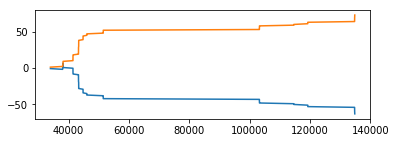

---
	-6.20	+44.00	+44.00
---
pred_knn_20_1: 	 +1.30 	 +5 	 +0.26
pred_knn_30_1: 	 +1.30 	 +5 	 +0.26
pred_knn_100_1: 	 +1.30 	 +5 	 +0.26
pred_knn_10_1: 	 +1.30 	 +5 	 +0.26
pred_knn_40_1: 	 +2.30 	 +4 	 +0.57
pred_gbr_20_1: 	 -4.00 	 +4 	 -1.00
pred_gbr_30_1: 	 -4.00 	 +4 	 -1.00
pred_gbr_40_1: 	 -4.00 	 +4 	 -1.00
pred_gbr_10_1: 	 +2.30 	 +4 	 +0.57
pred_gbr_100_1: 	 -4.00 	 +4 	 -1.00


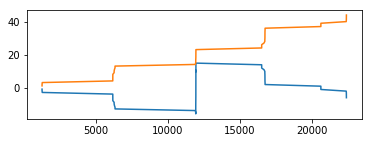

---
FINALE_REGIONALE_ACCAF	-29.80	+33.00	+33.00
---
pred_knn_20_1: 	 -4.00 	 +4 	 -1.00
pred_knn_30_1: 	 -4.00 	 +4 	 -1.00
pred_knn_10_1: 	 -4.00 	 +4 	 -1.00
pred_gbr_20_1: 	 -3.00 	 +3 	 -1.00
pred_gbr_30_1: 	 -3.00 	 +3 	 -1.00
pred_gbr_40_1: 	 -3.00 	 +3 	 -1.00
pred_knn_100_1: 	 +0.20 	 +3 	 +0.07
pred_gbr_10_1: 	 -3.00 	 +3 	 -1.00
pred_knn_40_1: 	 -3.00 	 +3 	 -1.00
pred_gbr_100_1: 	 -3.00 	 +3 	 -1.00


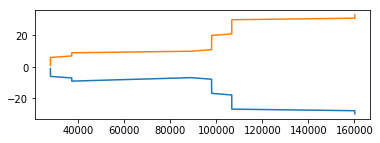

---
COURSE_INTERNATIONALE	-13.00	+13.00	+13.00
---
pred_knn_40_1: 	 -2.00 	 +2 	 -1.00
pred_knn_100_1: 	 -2.00 	 +2 	 -1.00
pred_knn_10_1: 	 -2.00 	 +2 	 -1.00
pred_gbr_20_1: 	 -1.00 	 +1 	 -1.00
pred_gbr_30_1: 	 -1.00 	 +1 	 -1.00
pred_knn_30_1: 	 -1.00 	 +1 	 -1.00
pred_gbr_40_1: 	 -1.00 	 +1 	 -1.00
pred_gbr_100_1: 	 -1.00 	 +1 	 -1.00
pred_gbr_10_1: 	 -1.00 	 +1 	 -1.00
pred_knn_20_1: 	 -1.00 	 +1 	 -1.00


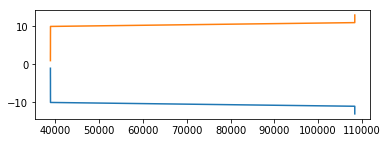

---
MIXTE	-3.00	+3.00	+3.00
---
pred_knn_20_1: 	 -1.00 	 +1 	 -1.00
pred_knn_100_1: 	 -1.00 	 +1 	 -1.00
pred_knn_30_1: 	 -1.00 	 +1 	 -1.00


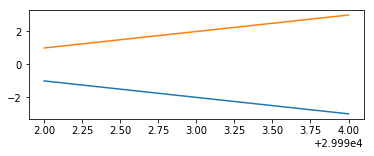

In [24]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

#bb = bets.groupby('id').filter(lambda r: r['num'].nunique() == 1 ).copy()
#bb = bets.copy()
bb = bets[(bets['target'].str.contains('^pred_gbr')) | (bets['target'].str.contains('^pred_knn'))  ].groupby('id').filter(lambda r: r['num'].count() <= 59 ).copy()
#bb = bets.groupby('id').filter(lambda r: (r['target'] == 'pred_mlp_1').sum() == 0 and (r['target'] == 'pred_knn_10_1').sum() == 1  )

def f(r):
    n1 = r[(r['target'] == 'pred_mlp_40_1')]['num']
    n2 = r[(r['target'] == 'pred_mlp_30_1')]['num']
    
    if not len(n1) and len(n2):
        return True
    if not len(n2) and len(n1):
        return True
    
    if n1.max() != n2.max():
        return True
    
    return False

#bb = bets.groupby('id').filter(f)

f = 'sub_category'

for s in bb[f].value_counts().index:
    x = bb[bb[f] == s].copy()
    print("---\n{}\t{:+.2f}\t{:+.2f}\t{:+.2f}\n---".format(s, x['profit'].sum(), x['bet'].sum(), len(x)))
    for t in x['target'].value_counts().index:
        bbb = x[(x['target'] == t) & (x['pred_std']!=0) ].copy()
        print("{:10s}: \t {:+.2f} \t {:+.0f} \t {:+.2f}".format(t, bbb.profit.sum(), bbb.profit.count(), bbb.profit.mean()) )
        
    x['stash'] = x['profit'].cumsum()
    x['cbet'] = x['bet'].cumsum()

    fig, axs = plt.subplots(1,1)
    x['stash'].plot(figsize=(6, 2))
    x['cbet'].plot(figsize=(6, 2))
    plt.show()

In [15]:
bets.columns


Index(['id', 'date', 'num', 'odds_ref', 'odds_final', 'target', 'pred',
       'pred_std', 'bet', 'profit', 'declared_player_count',
       'handicap_distance', 'handicap_distance_amax', 'handicap_distance_amin',
       'handicap_distance_mean', 'handicap_distance_r',
       'handicap_distance_std', 'handicap_weight', 'handicap_weight_amax',
       'handicap_weight_amin', 'handicap_weight_mean', 'handicap_weight_r',
       'handicap_weight_std', 'hist_1_pos', 'hist_2_pos', 'hist_3_pos',
       'hist_4_pos', 'hist_5_pos', 'hist_6_pos', 'odds_0', 'odds_1', 'odds_2',
       'odds_3', 'odds_4', 'odds_5', 'odds_6', 'odds_7', 'odds_8', 'odds_9',
       'placed_2_count', 'placed_2_count_amax', 'placed_2_count_amin',
       'placed_2_count_mean', 'placed_2_count_r', 'placed_2_count_std',
       'placed_3_count', 'placed_3_count_amax', 'placed_3_count_amin',
       'placed_3_count_mean', 'placed_3_count_r', 'placed_3_count_std',
       'placed_earnings', 'placed_earnings_amax', 'placed_earnings

In [16]:
bets[bets['profit'] < 0]['pred_std'].describe()

count    1.463250e+05
mean     7.739734e-01
std      9.603803e-01
min      0.000000e+00
25%      4.796712e-16
50%      5.099536e-01
75%      1.186045e+00
max      1.256322e+01
Name: pred_std, dtype: float64